# Crime data - San Francisco
---

https://www.youtube.com/watch?v=eYVCH61fKyY

https://www.trulia.com/real_estate/San_Francisco-California/crime/

https://www.neighborhoodscout.com/about-the-data/crime-rates

http://darribas.org/gds_scipy16/content/infrastructure/ ## create virtual env following this link

https://github.com/darribas/gds_scipy16

https://data.sfgov.org/Public-Safety/Police-Department-Incidents/tmnf-yvry/data

https://dev.socrata.com/foundry/data.sfgov.org/cuks-n6tp ## using API

In [1]:
import pysal as ps
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import datetime
import prettyplotlib as ppl

from scipy import stats
import statsmodels.api as sm
pd.set_option("max_columns", None)
sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/Javier/anaconda2/envs/gds-scipy16/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#####################
### Using Socrata
#####################
# from sodapy import Socrata
# def data_set_socrata(num):
#     client = Socrata("data.sfgov.org", None)
#     results = client.get("cuks-n6tp", limit=num)
#     df = pd.DataFrame.from_records(results)
#     return df
# sfcrime = data_set_socrata(2150000)
# print(sfcrime.shape)
# sfcrime.head(4)
# sfcrime.rename(columns={'pddistrict': 'PdDistrict', 
#                         'x': 'longitude',
#                         'y': 'latitude',
#                         'category' : 'Category',
#                         'date' : 'Date'}, inplace=True)
# ## time columns
# sfcrime.Date = pd.to_datetime(sfcrime.Date)
# sfcrime.set_index("Date", inplace=True)
# sfcrime['year'] = sfcrime.index.year
# sfcrime['month'] = sfcrime.index.month
# sfcrime['day'] = sfcrime.index.day

In [3]:
#####################
### Dowloaded dataset
#####################
sfcrime = pd.read_csv('../data/Police_Department_Incidents_11.csv')
sfcrime.Date = pd.to_datetime(sfcrime.Date)
sfcrime.set_index("Date", inplace=True)
sfcrime['year'] = sfcrime.index.year
sfcrime['month'] = sfcrime.index.month
sfcrime['day'] = sfcrime.index.day

#####################
sfcrime.rename(columns={'Y': 'latitude', 
                        'X': 'longitude'}, inplace=True)
sfcrime['Category'].replace("LARCENY/THEFT","LARCENY_THEFT", inplace=True )
sfcrime[sfcrime['Category'] =='DRUNKENNESS'].Descript.value_counts()

''' Seasonality
    Spring = March, April, May
    Summer = June, July, August
    Fall = September, October, November
    Winter = December, January, February
'''
sfcrime['seasons'] = sfcrime['month']
sfcrime['seasons'] = sfcrime['seasons'].map({3: "Spring", 4: "Spring", 5: "Spring",
                                             6: "Summer", 7: "Summer", 8: "Summer",
                                             9: "Fall", 10: "Fall", 11: "Fall",
                                             12: "Winter", 1: "Winter", 2: "Winter"})

In [4]:
print (sfcrime.shape)
sfcrime.head(3)

(2142686, 16)


IncidntNum      Category                              Descript  \
Date                                                                         
2015-01-19   150060275  NON-CRIMINAL                         LOST PROPERTY   
2015-02-01   150098210       ROBBERY                 ROBBERY, BODILY FORCE   
2015-02-01   150098210       ASSAULT  AGGRAVATED ASSAULT WITH BODILY FORCE   

           DayOfWeek   Time  PdDistrict Resolution  \
Date                                                 
2015-01-19    Monday  14:00     MISSION       NONE   
2015-02-01    Sunday  15:45  TENDERLOIN       NONE   
2015-02-01    Sunday  15:45  TENDERLOIN       NONE   

                                Address   longitude   latitude  \
Date                                                             
2015-01-19        18TH ST / VALENCIA ST -122.421582  37.761701   
2015-02-01  300 Block of LEAVENWORTH ST -122.414406  37.784191   
2015-02-01  300 Block of LEAVENWORTH ST -122.414406  37.784191   

                                         Location            PdId  year  \
Date                                                                      
2015-01-19   (37.7617007179518, -122.42158168137)  15006027571000  2015   
2015-02-01  (37.7841907151119, -122.414406029855)  15009821003074  2015   
2015-02-01  (37.7841907151119, -122.414406029855)  15009821004014  2015   

            month  day seasons  
Date                            
2015-01-19      1   19  Winter  
2015-02-01      2    1  Winter  
2015-02-01      2    1  Winter

In [6]:
#https://altair-viz.github.io/
import altair as alt
from altair import *
from altair import Chart, Color, Scale, X, Y
from altair import Chart, Color, Scale
from IPython.display import display

def sub_frame(dataset, group_cols=['PdDistrict', 'year'], col_name = 'Category', category="ROBBERY"):
    '''Subsets the original dataframe to a category'''
    subset_frame =  dataset[dataset[col_name] == category]
    '''Group by group_cols and category, returns df with number of occurrences'''
    group = subset_frame.groupby(group_cols)[col_name].count().reset_index()
    chart = alt.Chart(group)
    chart.configure_cell(height=400, width=600)
    graph = chart.mark_line().encode(
        X('year:T', axis=Axis(title='Years')),
        Y('Category:Q', axis=Axis(title='Number of ' + category.lower() +" incidents" )),
        color='PdDistrict',)
    display(graph)
    name =  'Trends_'+category
    path = '../graphs/'
    chart.savechart(path+name+'.html')
    #return graph

In [7]:
""" Notes from https://www.neighborhoodscout.com/about-the-data/crime-rates"""
'''Property Crimes
Larceny-Theft : The unlawful taking of property from the possession of another (excluding motor vehicles).
Burglary : The unlawful entry of a structure to commit a felony or a theft.
Vehicle Theft : The theft or attempted theft of a motor vehicle.
'''
#LARCENY_THEFT, BURGLARY, VEHICLE THEFT

'''Violent Endangerment / Violent Crimes
Homicide : The willful (nonnegligent) killing of one human being by another.
Armed Robbery : The taking or attempting to take anything of value from a person(s) by force or threat of violence.
Suicide = Suicide is defined as the act or instance of taking one’s own life, voluntarily or intentionally, in order to escape 
from an unbearable psychological or physical situation.
SECONDARY CODES and Description of DOMESTIC VIOLENCE
'''
#ROBBERY, SUICIDE, SECONDARY CODES(DOMESTIC VIOLENCE)

'''Related to Acohol
DRIVING UNDER THE INFLUENCE
DRUNKENNESS = UNDER INFLUENCE OF ALCOHOL IN A PUBLIC PLACE
'''
#DRUNKENNESS,DRIVING UNDER THE INFLUENCE 


'Related to Acohol\nDRIVING UNDER THE INFLUENCE\nDRUNKENNESS = UNDER INFLUENCE OF ALCOHOL IN A PUBLIC PLACE\n'

In [8]:
'''What has been the trend on property crimes'''
# prop_crimes = ['LARCENY_THEFT', 'BURGLARY', 'VEHICLE THEFT']
# for crime in prop_crimes:
#     sub_frame(sfcrime, group_cols=['PdDistrict', 'year'],  col_name = 'Category', category=crime)

'What has been the trend on property crimes'

In [9]:
'''Violent Endangerment / Violent Crimes'''
# violent_crimes = ['ROBBERY', 'SUICIDE']
# #SECONDARY CODES(DOMESTIC VIOLENCE)
# for crime in violent_crimes:
#     sub_frame(sfcrime, group_cols=['PdDistrict', 'year'],  col_name = 'Category', category=crime)   

'Violent Endangerment / Violent Crimes'

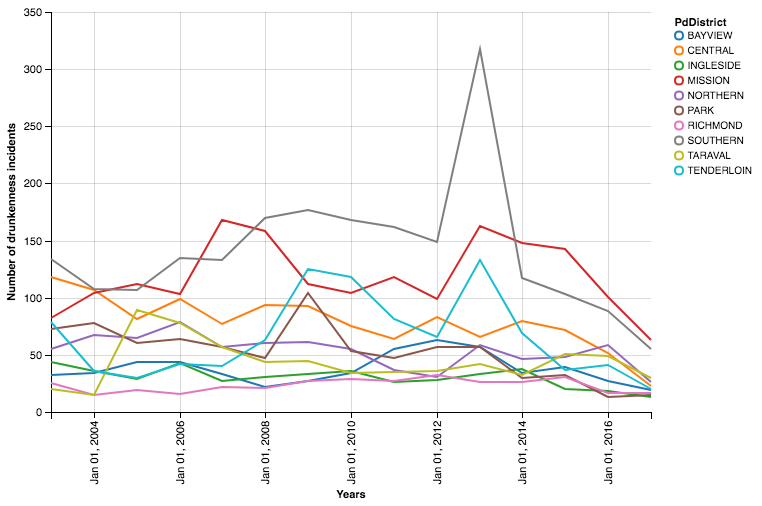

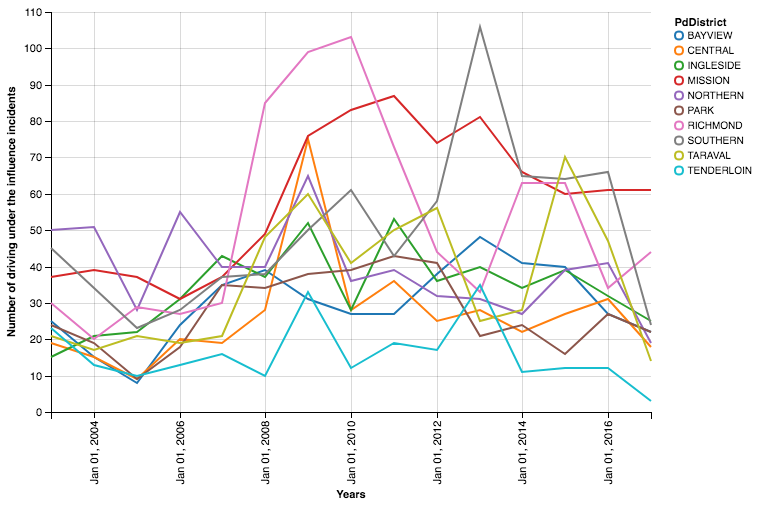

In [10]:
'''Related to alcohol'''
alcohol_crimes = ['DRUNKENNESS','DRIVING UNDER THE INFLUENCE']
for crime in alcohol_crimes:
    sub_frame(sfcrime, group_cols=['PdDistrict', 'year'],  col_name = 'Category', category=crime) 

In [11]:
def grap_subset(dataset, col_name='Category',  category='LARCENY_THEFT', date_col = 'year', number = 2016,
                group_cols=['PdDistrict', 'Date']):
    subset_frame =  dataset[(dataset[col_name] ==category) & (sfcrime[date_col] == number)].reset_index()
    group = subset_frame.groupby(group_cols)[col_name].count().reset_index()
    #return group
    chart = alt.Chart(group)
    chart.configure_cell(height=400, width=1000)
    graph = chart.mark_area().encode(color=Color('PdDistrict:N', scale=Scale(range='category20b', ),),
        x=X('Date:T', axis=Axis(
            axisWidth=0.5,
            #format='%M',
            labelAngle=0.0, title =date_col+" "+str(number)
        ),
        scale=Scale(
            nice='month',
        ),
        timeUnit='month', 
        ),
        y=Y('sum(Category):Q', axis=Axis(title ="Cumulative number of "+category.lower()+" incidents")))
    display(graph)
    name =  'Trends_'+category+" in "+date_col+" "+str(number)
    path = '../graphs/'
    chart.savechart(path+name+'.html')  

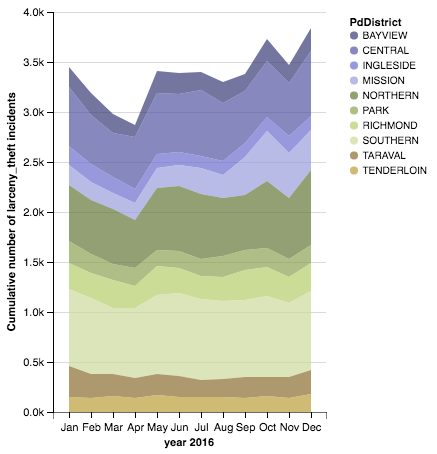

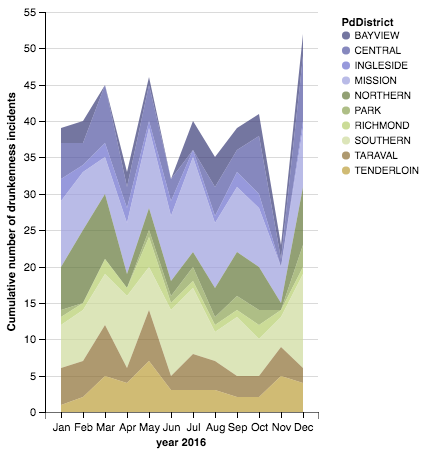

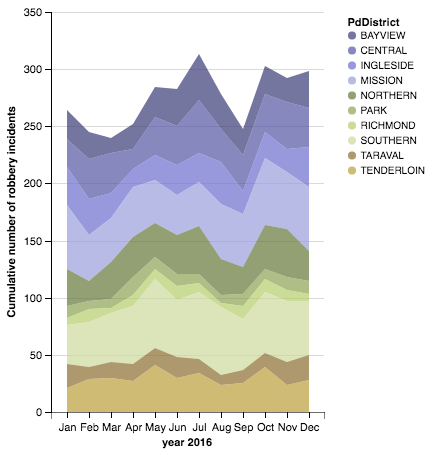

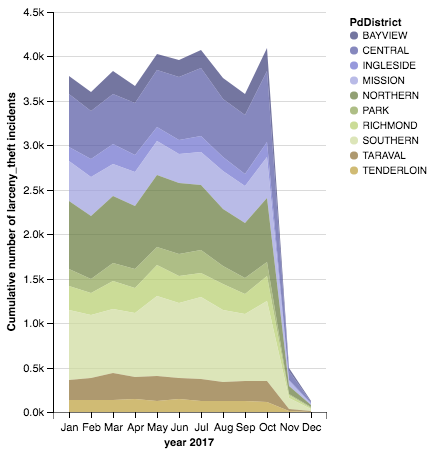

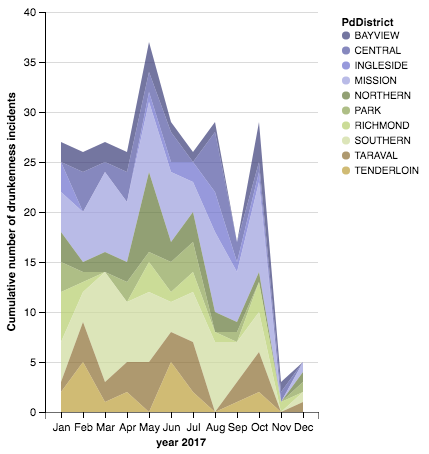

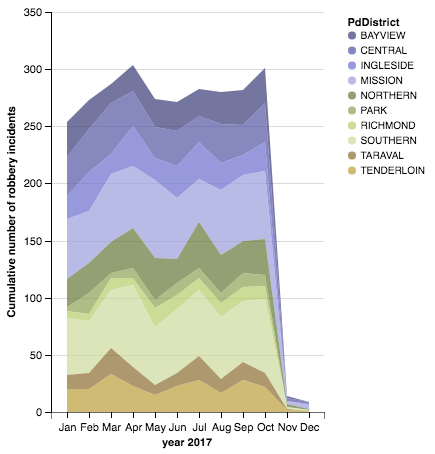

In [12]:
'''Closer look to robery, drunkeness and larceny thert'''
#LARCENY_THEFT, DRUNKENNESS, ROBBERY, 2016 and 2017
years = [2016, 2017]
main_crimes = ['LARCENY_THEFT', 'DRUNKENNESS', 'ROBBERY']
for year in years:
    for crime in main_crimes:
        grap_subset(sfcrime, col_name='Category',  category=crime, date_col = 'year', 
                    number = year, group_cols=['PdDistrict', 'Date'])


In [13]:
def subset_df_trends(dataset, group_by_col=['year'], category='BRIBERY', col_name='number_incidents'):
    '''Returns subsets df'''
    font_title = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 14,}
    font_axis = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 12,}
    
    df_none = dataset.groupby(group_by_col).size().reset_index()
    df_none.rename(columns={0:col_name}, inplace=True)
    
    df = dataset[dataset['Category']==category].groupby(group_by_col).size().reset_index()
    df.rename(columns={0:col_name}, inplace=True)
    
    fig = plt.figure(figsize=(13,9))
    
    plt.subplot(2, 1, 1)
    plt.plot(df_none.year, df_none[col_name], '--', linewidth=2, label='Trend of All Incidents',color="r")
    text ='All Incidents \n'
    plt.title(text, fontdict=font_title)
    plt.ylabel('Cumulative Number\n', fontdict=font_axis)
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(df.year, df[col_name], '--', linewidth=2, label='Trend of '+ category.title()+ ' Incidents',color="y")
    text = "\n " + category.title() + ' Incidents'
    plt.title(text, fontdict=font_title)
    plt.ylabel('Cumulative Number\n', fontdict=font_axis)
    plt.xlabel('\nYears\n', fontdict=font_axis)
    plt.legend()
    
    path = '../graphs/'
    name = 'Trends all incidents and ' +category.title()
    plt.savefig(path+name+'.jpg')
    plt.show()   

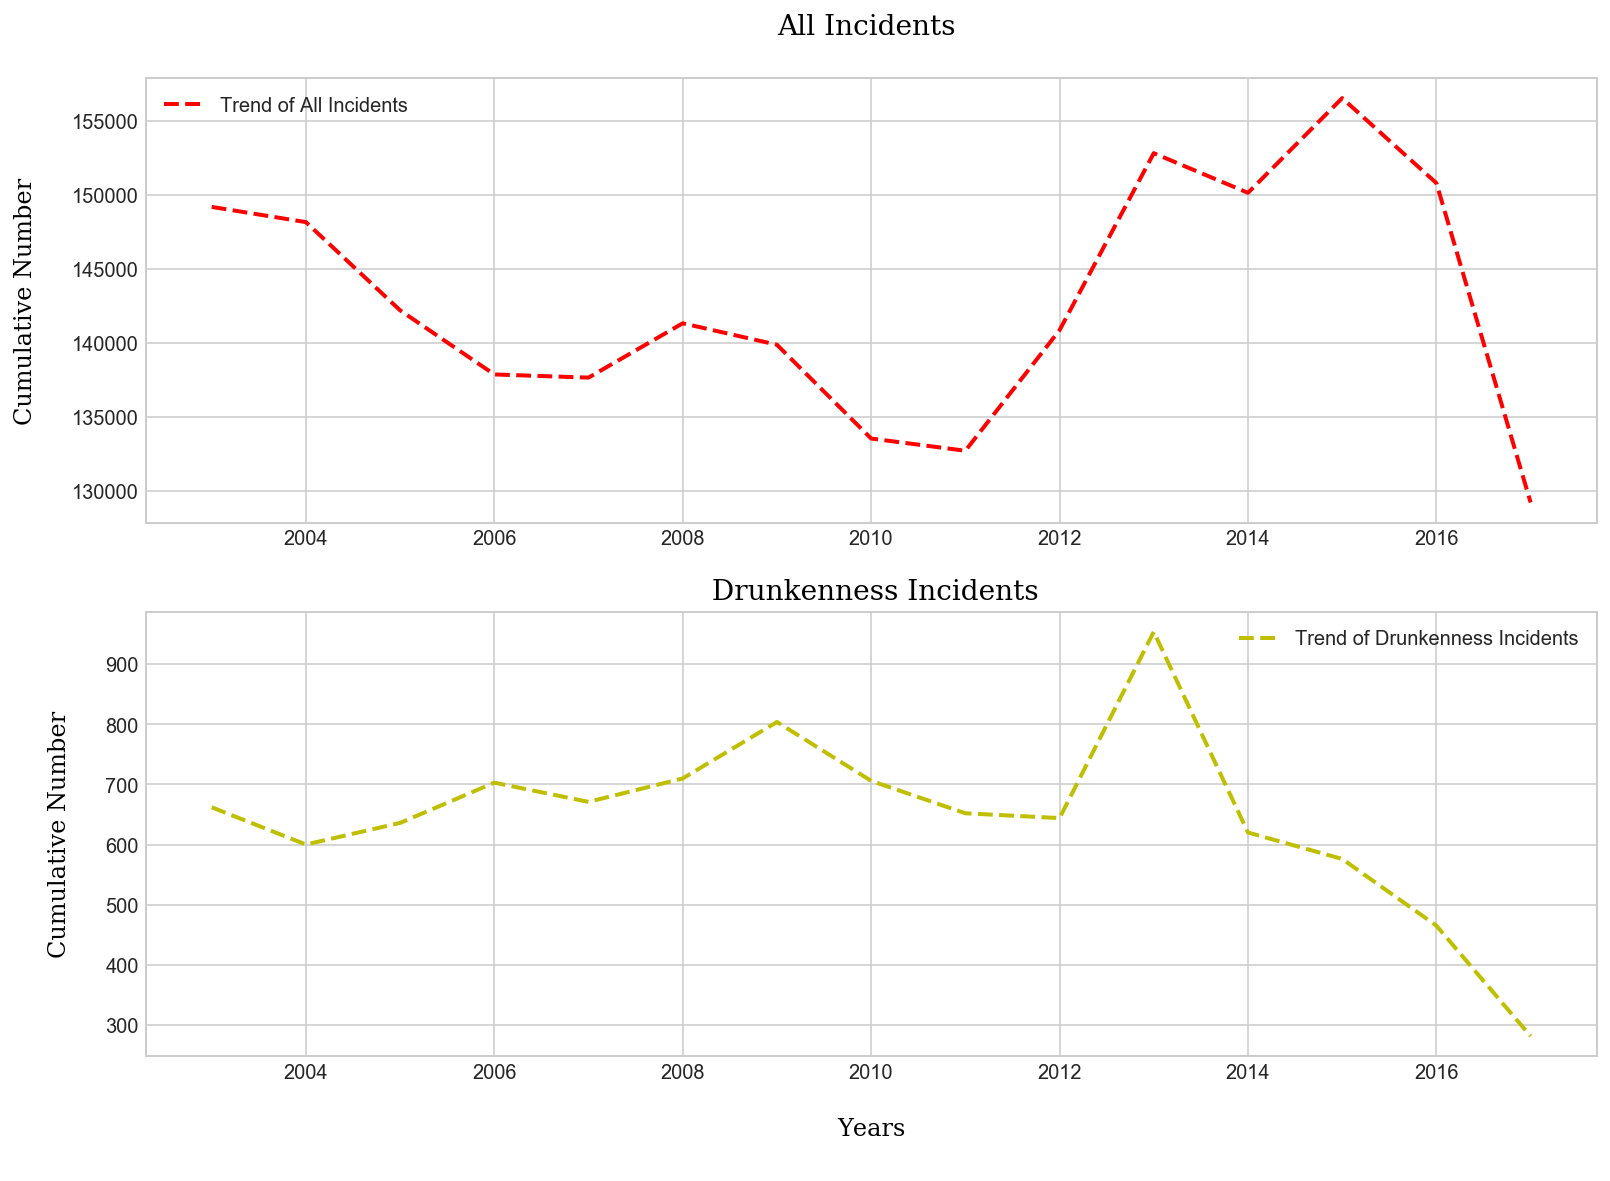

In [14]:
subset_df_trends(sfcrime,group_by_col=['year'], category='DRUNKENNESS', col_name='number_incidents')

In [15]:
"""Grouping by something dataset"""
def groupby_dataset(dataset, col_cat="Category", category='DRUNKENNESS', col_time='year', 
                    col_group='PdDistrict', col_name = 'number_incidents', time=2017):
    subset_frame = dataset[ (dataset[col_cat] == category) & (dataset[col_time] == time)]
    group = subset_frame.groupby(col_group).size().reset_index()
    group[col_time] = time
    group.rename(columns={0: col_name}, inplace=True)
    return group

In [16]:
'''Bar chart comparisson '''

exclude_year = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
years = sorted(list(set(sfcrime.year.values)))
df_holder = []
for i in [i for i in years if i not in exclude_year]:
    df = groupby_dataset(sfcrime, col_cat="Category", category='DRUNKENNESS', col_group='PdDistrict', 
                col_name = 'number_incidents', col_time='year', time=i)
    df_holder.append(df)
results = pd.concat(df_holder)
results.year.value_counts()
##########

def comparisson_graph(dataset, col_group='PdDistrict', col_name = 'number_incidents', col_time='year', 
                     category='DRUNKENNESS'):

    font_title = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 16,}
    font_axis = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 14,}
    font_inside_num = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 10,}
    
    fig = plt.figure(figsize=(15,8))
    ax = fig.gca()
    ax = sns.barplot(dataset[col_group], dataset[col_name], hue=dataset[col_time], 
                     ax=ax, palette=sns.color_palette("Paired", 20))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., ## put number in the middle
                height + 10, ## distance number to bar
                '{:1.1f}'.format(height),
                ha="center", fontdict=font_inside_num, rotation=35)
        
    text = category.title() + ' Incidents \n\n'
    plt.title(text, fontdict=font_title)
    plt.ylabel('Cumulative Number of incidents\n', fontdict=font_axis)
    plt.xlabel('\nDistricts\n', fontdict=font_axis)
    path = '../graphs/'
    name = category.title()+" "+str(col_time)+'s'
    plt.savefig(path+name+'.jpg')
    plt.show()

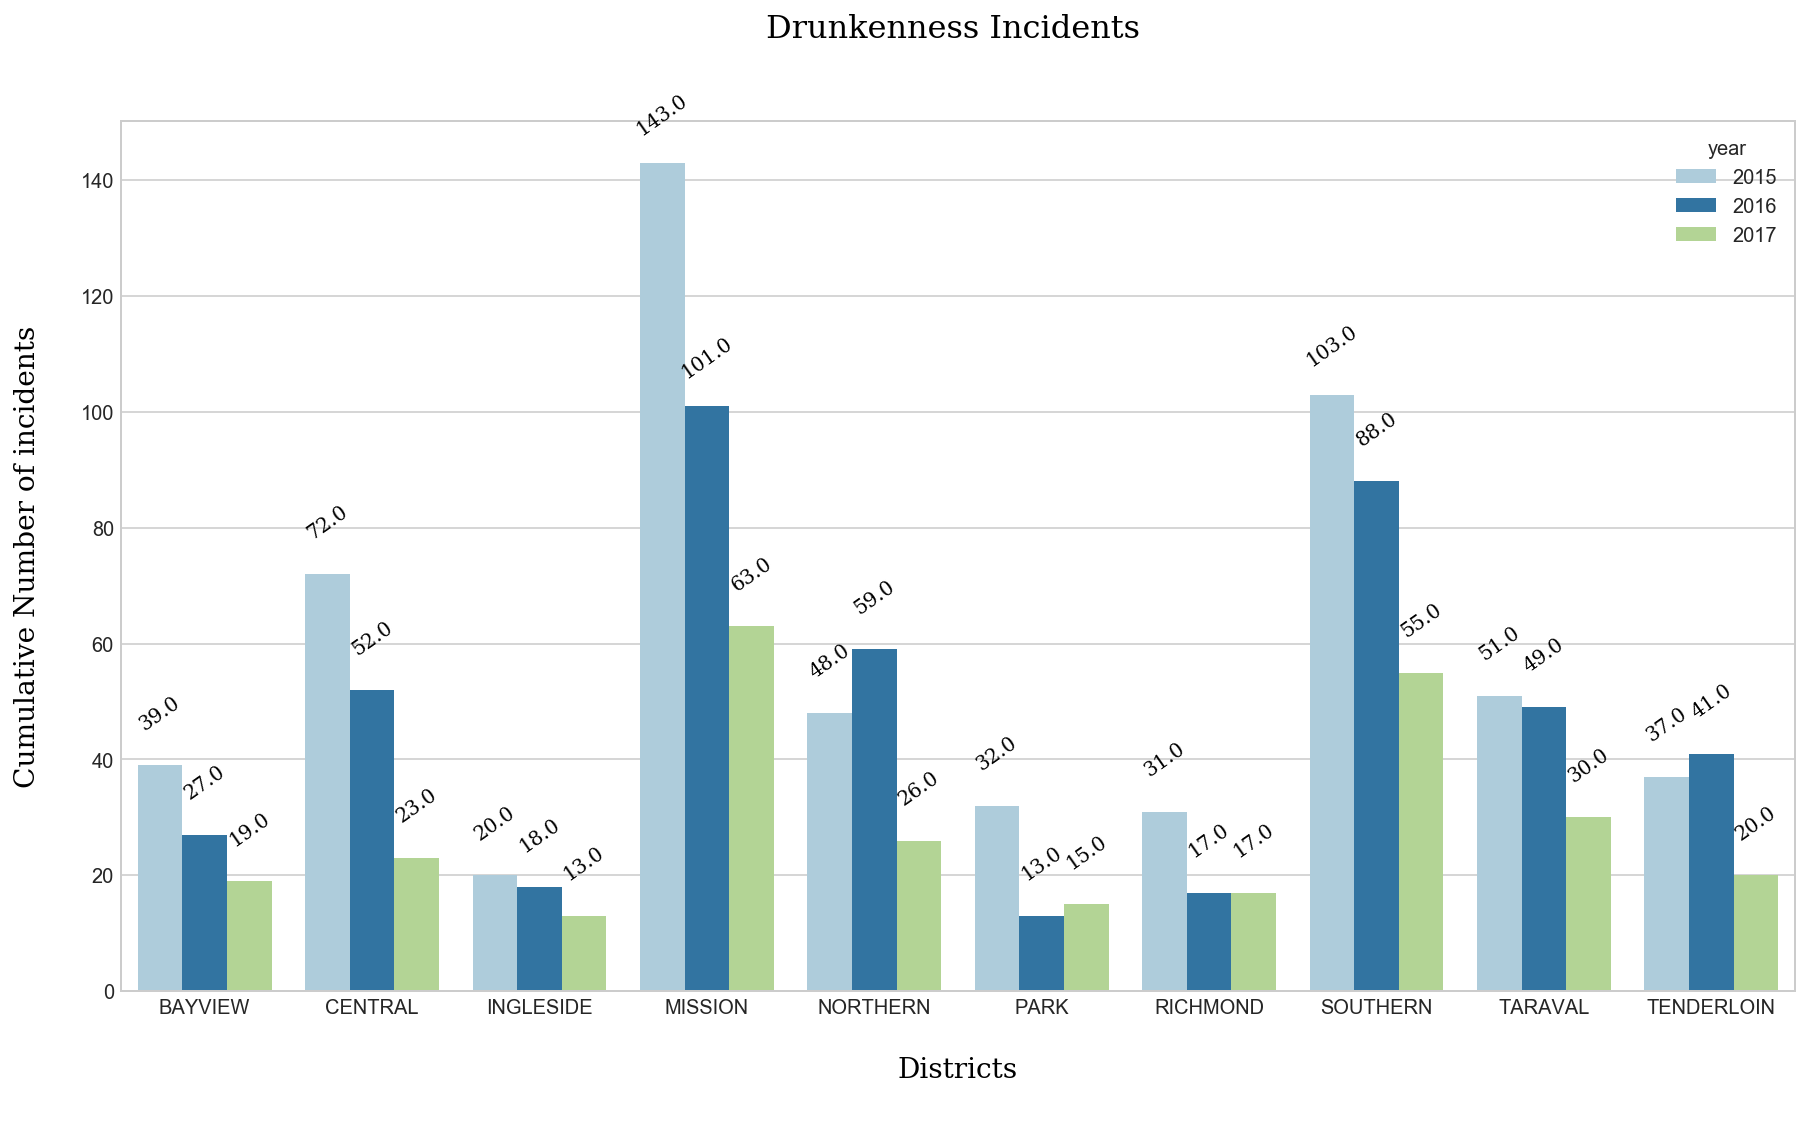

In [17]:
comparisson_graph(results, col_group='PdDistrict', col_name = 'number_incidents', col_time='year', 
                  category='DRUNKENNESS')

In [18]:
'''Bar chart comparisson seasons'''

exclude_year = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
years = sorted(list(set(sfcrime.year.values)))
df_holder = []
for i in [i for i in years if i not in exclude_year]:
    df = groupby_dataset(sfcrime, col_cat="Category", category='DRUNKENNESS', col_group='seasons', 
                col_name = 'number_incidents', col_time='year', time=i)
    df_holder.append(df)
season_df = pd.concat(df_holder)
season_df.year.value_counts()
##########
def comparisson_graph_season(dataset, col_group='PdDistrict', col_name = 'number_incidents', col_time='year', 
                     category='DRUNKENNESS'):

    font_title = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 16,}
    font_axis = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 14,}
    font_inside_num = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 10,}
    
    fig = plt.figure(figsize=(15,8))
    ax = fig.gca()
    ax = sns.barplot(dataset[col_name], dataset[col_group], hue=dataset[col_time], 
                     order=["Spring", "Summer", "Winter", "Fall"], 
                     ax=ax, palette=sns.color_palette("Set2", 10))
        
    text = category.title() + ' Incidents by Seasons\n'
    plt.title(text, fontdict=font_title)
    plt.ylabel('Seasons\n', fontdict=font_axis)
    plt.xlabel('\nCumulative Number of Incidents\n', fontdict=font_axis)
    path = '../graphs/'
    name = text+" "+str(col_time)
    plt.savefig(path+name+'.jpg')
    plt.show()


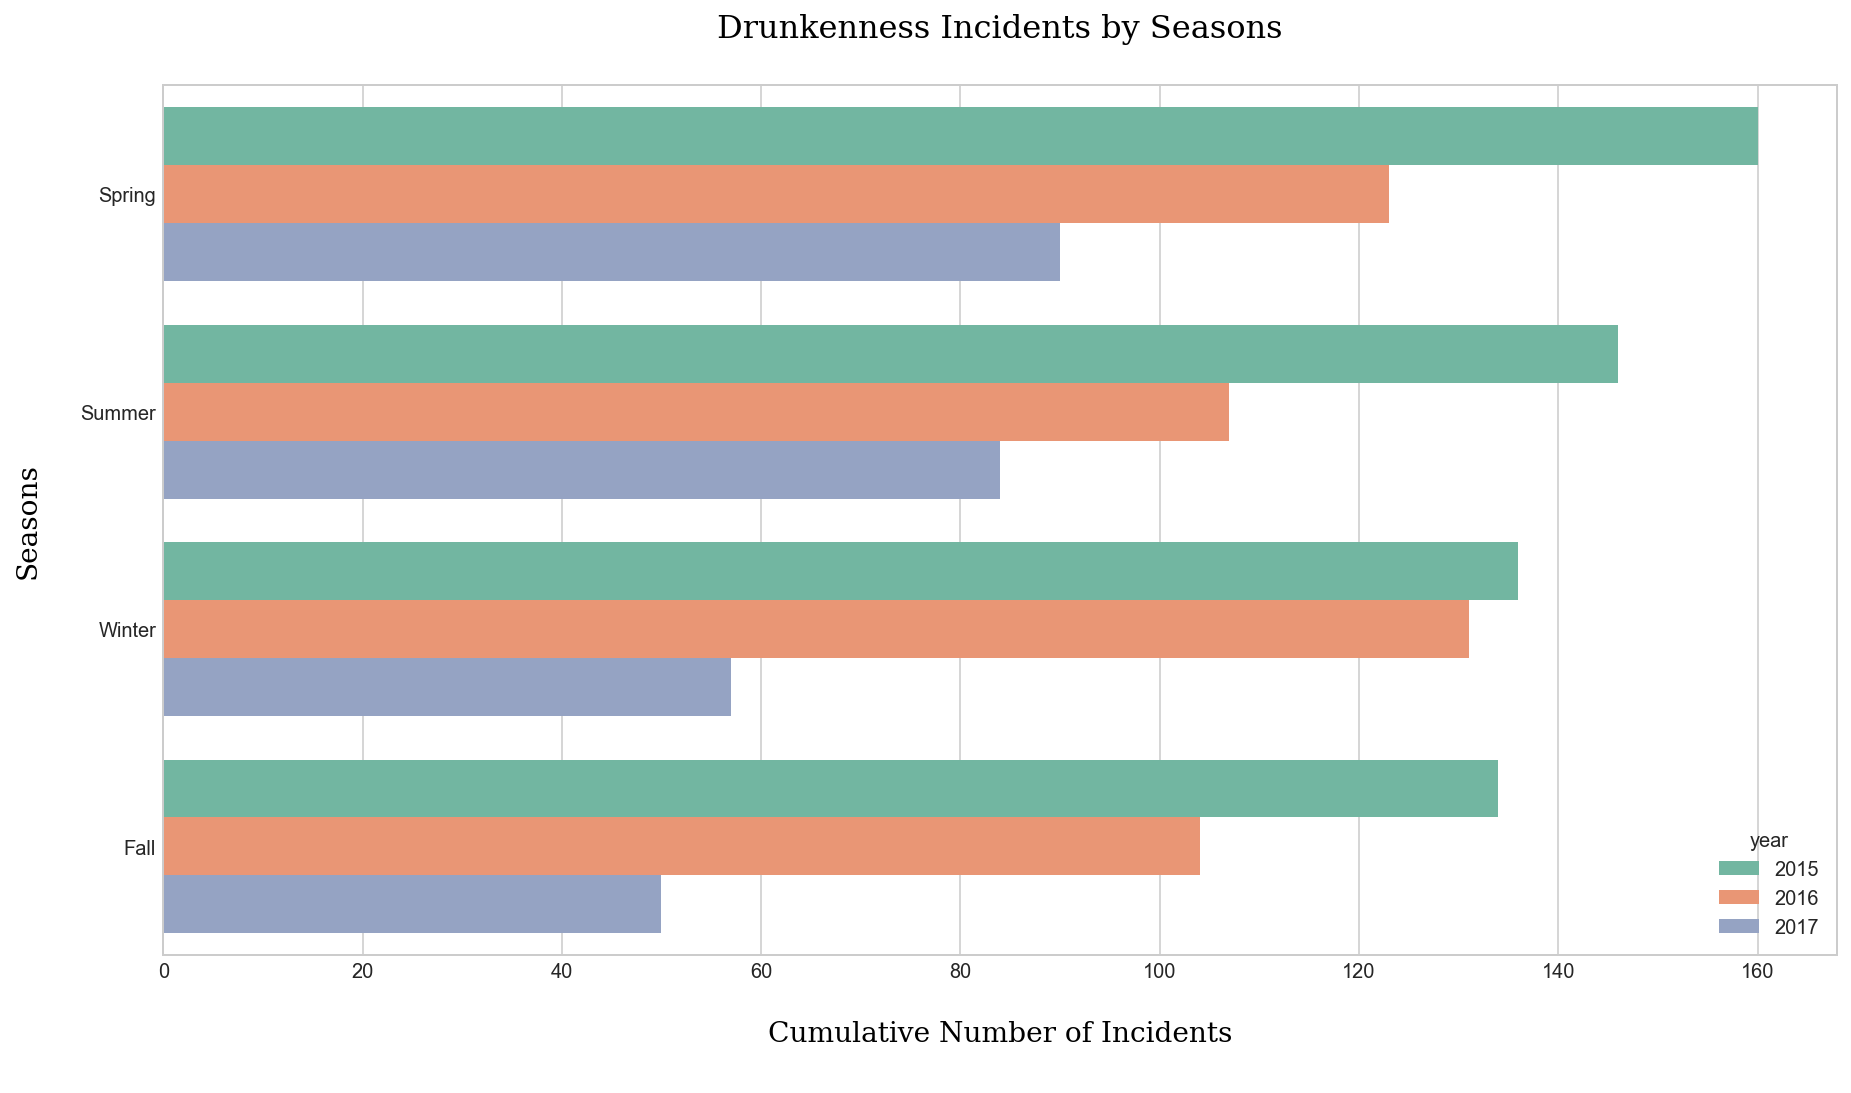

In [19]:
comparisson_graph_season(season_df, col_group='seasons', col_name = 'number_incidents', col_time='year', 
                     category='DRUNKENNESS')

In [20]:
#https://jiffyclub.github.io/palettable/
from palettable import colorbrewer as cb 
from palettable.colorbrewer.sequential import Blues_8

## Maps

In [21]:
'''Adding Geospatial context using mplleaflet'''
import mplleaflet
def sub_set_frame(dataset, col_cat="Category", category='LARCENY_THEFT', col_time='year', num=2016, 
                  graph_type = ['simple', 'advanced']):
    subset_frame = dataset[ (dataset[col_cat] == category) & (dataset[col_time] == num)]
    #return subset_frame
    plt.scatter(subset_frame['longitude'], subset_frame['latitude'])
    name = category+" "+col_time+" "+str(num)
    plt.title(name)
    if 'simple' in graph_type:
        plt.show()
    elif 'advanced' in graph_type:
        mplleaflet.show()
        #mplleaflet.display()

In [22]:
# years = [2016, 2017]
# main_crimes = ['DRUNKENNESS']
# ##'LARCENY_THEFT', 'DRUNKENNESS', 'ROBBERY'
# for year in years:
#     for crime in main_crimes:
#         sub_set_frame(sfcrime, col_cat="Category", category=crime ,col_time='year', num=year, 
#                       graph_type = ['simple'])    

In [23]:
'''When using list on main_crimes, graph may not display'''
years = [2016, 2017]
main_crimes = ['DRUNKENNESS']
#'LARCENY_THEFT', , 'ROBBERY'
for year in years:
    for crime in main_crimes:
        sub_set_frame(sfcrime, col_cat="Category", category=crime ,col_time='year', num=year, 
                      graph_type = ['advanced']) 

In [24]:
def sampling_data_points(dataset, col_cat="Category", category='LARCENY_THEFT', col_time='year',
                         num_1=2016, num_2=2017, num_sample=1000):
    frame_1 = dataset[(dataset[col_cat] == category) & (
        dataset[col_time] == num_1)].reset_index()
    frame_2 = dataset[(dataset[col_cat] == category) & (
        dataset[col_time] == num_2)].reset_index()
    if frame_1.shape[0] >= num_sample and frame_2.shape[0] >= num_sample:
        frame_1 = frame_1.sample(num_sample)
        frame_2 = frame_2.sample(num_sample)
    else:
        pass
    print ('incidents display for year ' + str(num_1) + ":"+
           str(frame_1.shape[0]), 'of ' + str(num_sample))
    print ('incidents display for year ' + str(num_2) + ":" +
           str(frame_2.shape[0]), 'of ' + str(num_sample))
    return frame_1, frame_2

In [25]:
'''Displaying map in notebook'''
frame_1, frame_2 = sampling_data_points(sfcrime, col_cat="Category", category='DRUNKENNESS', col_time='year', 
              num_1=2016, num_2=2017, num_sample=1000)

fig = plt.figure(figsize=(20,15))
ax = fig.gca()
ax = plt.scatter(frame_1['longitude'], frame_1['latitude'], marker="o", color="r", s=20, linewidths=1)
ax = plt.scatter(frame_2['longitude'], frame_2['latitude'], marker="x", color="black", s=20, linewidths=1)
mplleaflet.display(fig=ax.figure)

incidents display for year 2016:465 of 1000
incidents display for year 2017:281 of 1000


In [26]:
'''Function display map in server'''
def compare_years(dataset, col_cat="Category", category='LARCENY_THEFT', col_time='year', 
                  num_1=2016, num_2=2017, num_sample=1000):
    frame_1 = dataset[ (dataset[col_cat] == category) & (dataset[col_time] == num_1)].reset_index()
    frame_2 = dataset[ (dataset[col_cat] == category) & (dataset[col_time] == num_2)].reset_index()
    
    if frame_1.shape[0] >= num_sample and frame_2.shape[0] >= num_sample:
        frame_1 = frame_1.sample(num_sample)
        frame_2 = frame_2.sample(num_sample)
        print (frame_1.shape[0]), (frame_2.shape[0])
        plt.scatter(frame_1['longitude'], frame_1['latitude'], marker="o", color="r", s=20, linewidths=1)
        plt.scatter(frame_2['longitude'], frame_2['latitude'], marker="x", color="black", s=20, linewidths=1)
        mplleaflet.show()
    else:
        print (frame_1.shape[0]), (frame_2.shape[0])
        plt.scatter(frame_1['longitude'], frame_1['latitude'], marker="o", color="r", s=20, linewidths=1)
        plt.scatter(frame_2['longitude'], frame_2['latitude'], marker="x", color="black", s=20, linewidths=1)
        mplleaflet.show()

In [27]:
# LARCENY_THEFT', 'DRUNKENNESS', 'ROBBERY
'''Keep the num_sample to a max number of 1500 so one can see the graph, otherwise it wont open'''
compare_years(sfcrime, col_cat="Category", category='DRUNKENNESS', col_time='year', 
              num_1=2016, num_2=2017, num_sample=1500)

465


## Now lets get serious about plotting using geometries
Here we need:
1. Census tracks=>Census tracts are created every ten years for the census, and are built to try to contain either 4000 or 0 people (in the case of parks, beaches, etc.)



In [28]:
#http://geopandas.org/mapping.html
import geopandas as gpd

In [29]:
# #http://geopandas.org/mapping.html
# import geopandas as gpd
san_fran = gpd.read_file("../data/2010_census_tracts_neighborhoods/census_tracts.shp")
san_fran.head(3)

nhood    shape_len tractce10        geoid    shape_area  \
0      Hayes Valley  7589.679396    016400  06075016400  3.326589e+06   
1  Western Addition  8525.808755    016100  06075016100  3.970259e+06   
2  Western Addition  8000.966619    015900  06075015900  3.179072e+06   

                                            geometry  
0  POLYGON ((-122.4324669997095 37.77375700028448...  
1  POLYGON ((-122.4235409996432 37.77967400025458...  
2  POLYGON ((-122.4246870001921 37.78533500040309...

Fixing coordinates to EPSG => simple latitude-and-longitude reference system. This is accomplished by calling the `to_crs` method

In [30]:
print (san_fran.crs)
print (san_fran['geometry'].head())

{'init': 'epsg:4326'}
0    POLYGON ((-122.4324669997095 37.77375700028448...
1    POLYGON ((-122.4235409996432 37.77967400025458...
2    POLYGON ((-122.4246870001921 37.78533500040309...
3    POLYGON ((-122.4246870001921 37.78533500040309...
4    POLYGON ((-122.4349179998128 37.78587599994257...
Name: geometry, dtype: object


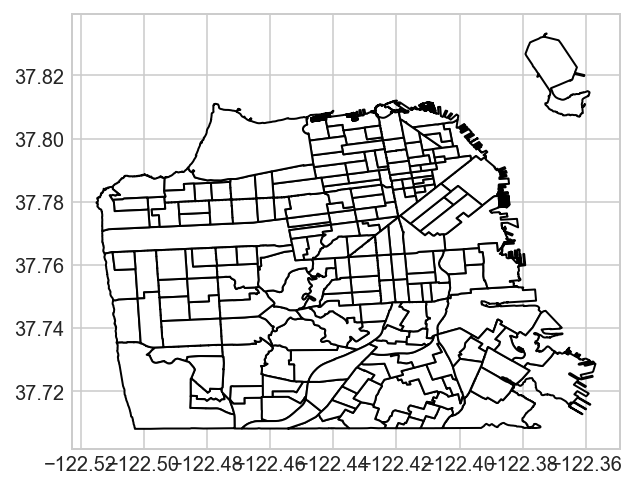

In [32]:
'''now lets plot === HAHAHA funfun''' 
san_fran.plot(color='white', edgecolor='black')
plt.show()

In [33]:
import shapely
'''Naive way of seeing concentration of incidents'''
def sub_frame_shape(dataset, col_cat="Category", category='LARCENY_THEFT', col_time='year', num=2016):
    subset_frame = dataset[ (dataset[col_cat] == category) & (dataset[col_time] == num)].reset_index()
    #return subset_frame
    subset_frame = gpd.GeoDataFrame(subset_frame, geometry=subset_frame.apply(
                   lambda srs: shapely.geometry.Point(srs['longitude'], srs['latitude']), axis='columns'))
    f = plt.figure(figsize=(15, 13))
    ax = f.gca()
    san_fran.plot(ax=ax, linewidth=0.25, color='white', edgecolor='black')
    sns.kdeplot(n_levels=25, cmap="Purples_d", data=subset_frame.apply(lambda srs: pd.Series({'x': srs.geometry.x, 
                'y': srs.geometry.y}), axis='columns'), ax=ax, alpha=1)
    ax.set_axis_off()
    plt.show()

/Users/Javier/anaconda2/envs/gds-scipy16/lib/python3.6/site-packages/seaborn/distributions.py:645: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


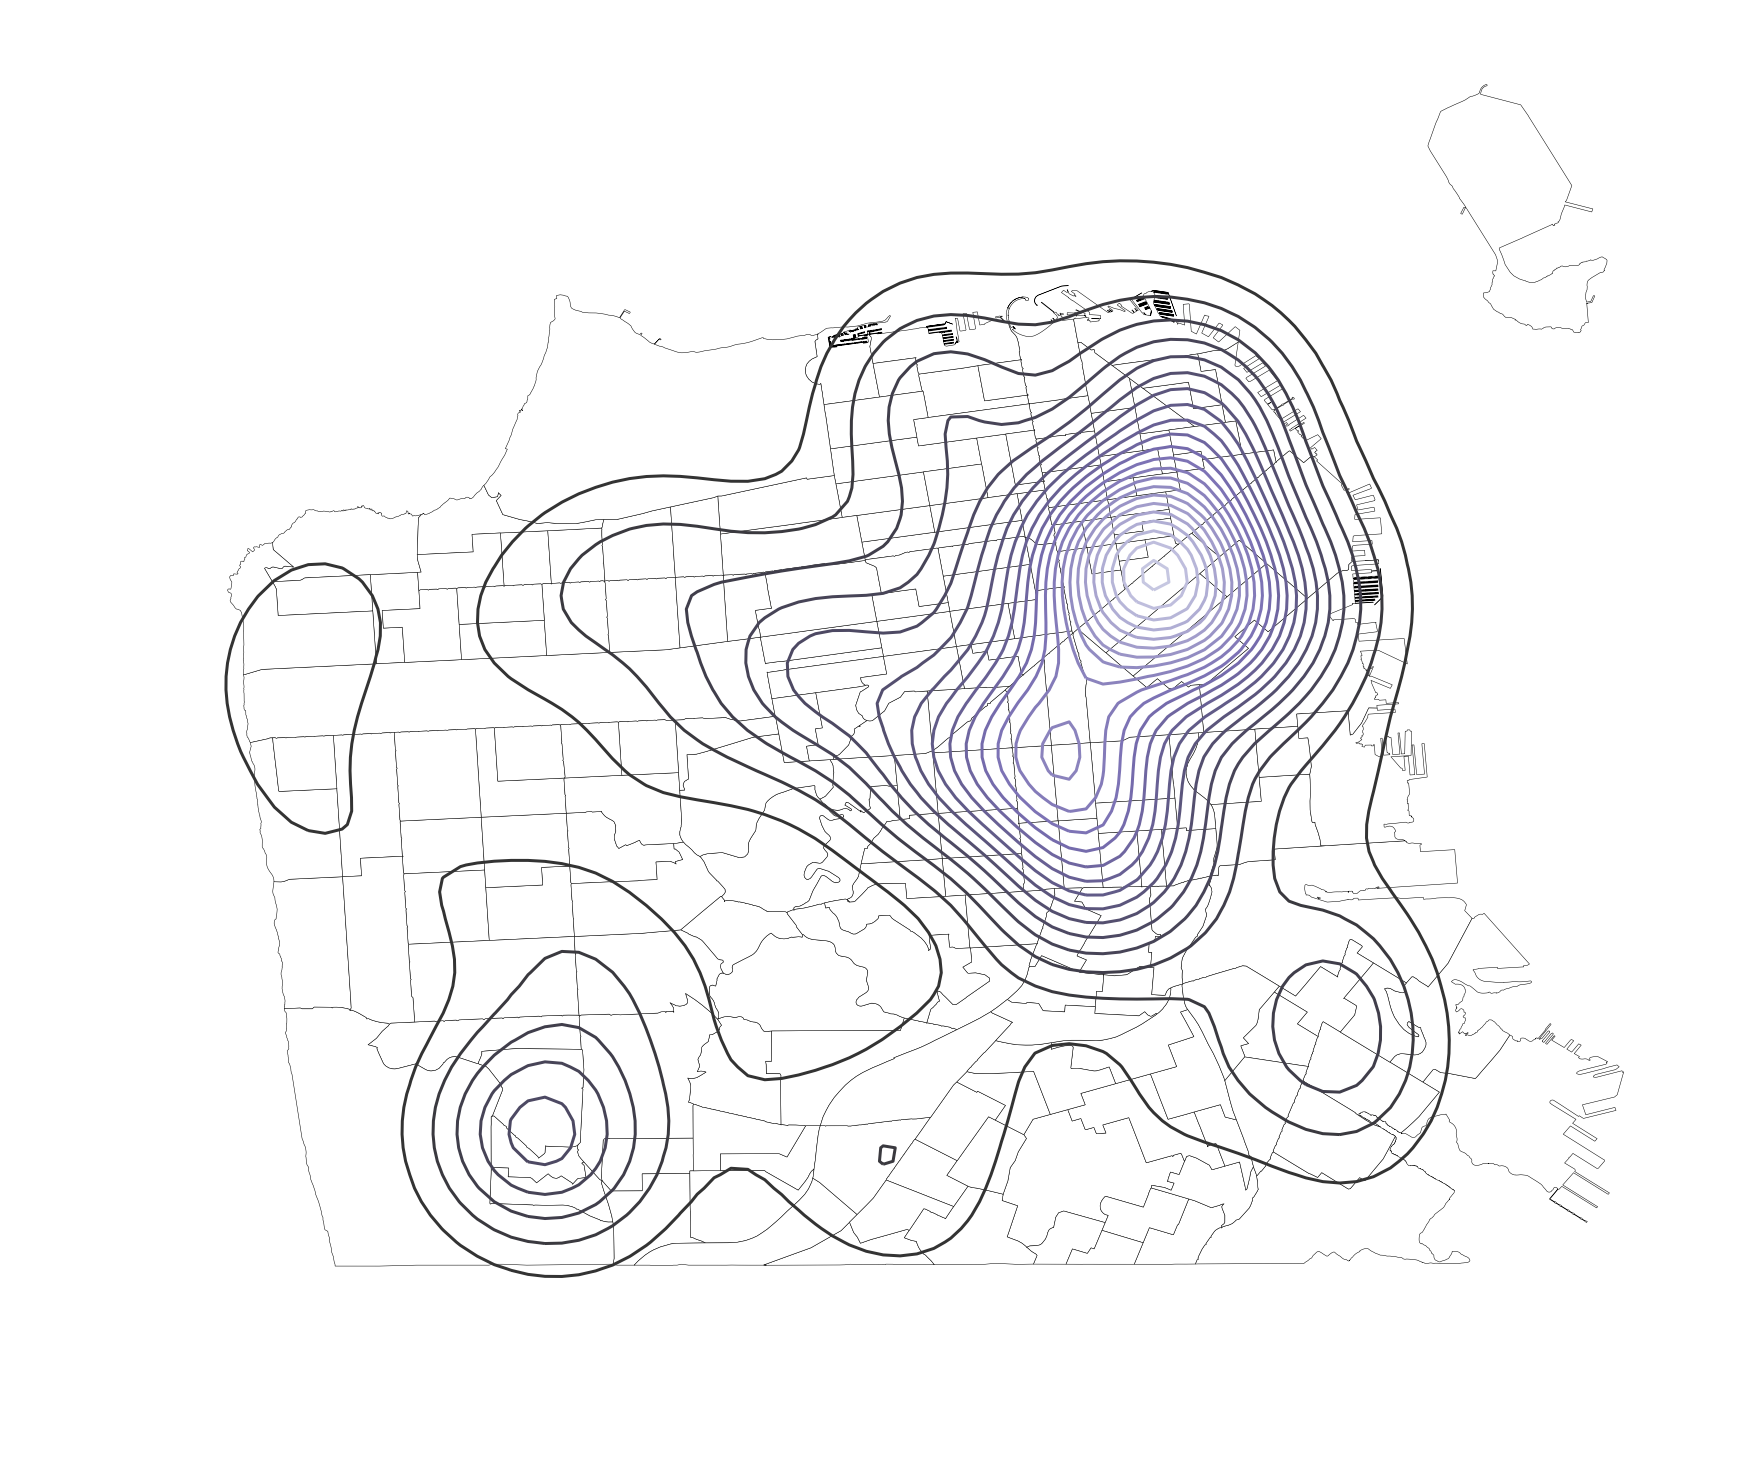

In [34]:
sub_frame_shape(sfcrime, col_cat="Category", category='DRUNKENNESS', col_time='year', num=2017)

## More granular approach using Choropleth map
#### Spatial Weights and Spatial Lag
1. Count and density
2. Assuming that the census tracts are neighbors so long as they touch at least at an edge, thus using queen continuity
3. Examining spatial lag allows helps to understand the statistical significance of our previus result, thus using Moran autocorrelation analysis

In [35]:
'''Choropleth maps'''
qW = ps.queen_from_shapefile('../data/2010_census_tracts_neighborhoods/census_tracts.shp')

def create_censtract(holder):
    bools = [geom.contains(holder['geometry']) for geom in san_fran['geometry']]
    if True in bools:
        return san_fran.iloc[bools.index(True)]['tractce10']
    else:
        return np.nan
    
def sub_frame_choro(dataset, track_df, col_cat="Category", category='LARCENY_THEFT', 
                    col_time='year', num=2016, type_graph=['density', 'count', 'spatial_lag']):
    
    subset_frame = dataset[ (dataset[col_cat] == category) & (dataset[col_time] == num)].reset_index()
    subset_frame = gpd.GeoDataFrame(subset_frame, geometry=subset_frame.apply(
                   lambda srs: shapely.geometry.Point(srs['longitude'], srs['latitude']), axis='columns'))
   
    holder_1=subset_frame.columns.tolist()
    if "census_tract" in holder_1:
        subset_frame.drop('census_tract', axis=1, inplace=True)
    else:
        subset_frame['census_tract'] = subset_frame.apply(create_censtract, axis='columns')
    
    '''Columns for number of occurrences of incident and density'''
    holder_2  = track_df.columns.tolist()
    if "choro_map" in holder_2:
        track_df.drop("choro_map", axis=1, inplace=True)
    else:
        track_df["choro_map"] = track_df['tractce10'].map(subset_frame['census_tract'].value_counts())
        track_df['choro_map'].fillna(0, inplace=True)
        track_df['choro_map_dens'] = (track_df['choro_map'] / track_df['geometry'].to_crs({'init': 
                                 'epsg:3395'}).map(lambda p: p.area / 10**6)).fillna(0)
      
    if 'count' in type_graph:
        f = plt.figure(figsize=(15, 13))
        ax = f.gca()
        kw = dict(column='choro_map', k=7, cmap='YlGnBu', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
        track_df.plot(scheme='QUANTILES', ax=ax, **kw)
        ax.set_axis_off()
#         path = '../graphs/'
#         name = 'map count'+" "+str(num)
#         plt.savefig(path+name+'.jpg')
        plt.show()
        
    elif 'density'in type_graph:
        f = plt.figure(figsize=(15, 13))
        ax = f.gca()
        kw = dict(column='choro_map_dens', k=7, cmap='Pastel2_r', alpha=1, legend=True, edgecolor='gray', 
              linewidth=0.5)
        track_df.plot(scheme='QUANTILES', ax=ax, **kw)
        ax.set_axis_off()
        path = '../graphs/'
        name = 'map density'+" "+str(num)
        plt.savefig(path+name+'.jpg')
        plt.show()
        
    elif 'spatial_lag' in type_graph:
        '''Is the data geographically dependent?'''
        spat_lags = ps.lag_spatial(qW, track_df['choro_map_dens'])
        spat_lag_classes = ps.Quantiles(spat_lags, k=5)
        
        f = plt.figure(figsize=(15, 13))
        ax = f.gca()
        kw = dict(column='spatial_class', k=7, cmap='Pastel2', alpha=1, legend=True, edgecolor='gray', 
                  linewidth=0.5, categorical=True)
        track_df.assign(spatial_class=spat_lag_classes.yb).plot(ax=ax, **kw)
        ax.set_axis_off()
        path = '../graphs/'
        name = 'map spatial_lag'+" "+str(num)
        plt.savefig(path+name+'.jpg')
        plt.show()
        #chrome-extension://gbkeegbaiigmenfmjfclcdgdpimamgkj/views/app.html
        moran = ps.Moran(track_df['choro_map_dens'].values, qW)
        text_1 = "The Moran's spatial autocorrelation value is: " + str(moran.I)
        text_2 = "It has a p-value of "+str(moran.p_sim)+" which shows that there is a less than "+str((moran.p_sim)*100)+"%" 
        text_3 = "probability that the distribution of the data is heavily skewed."
        print (text_1)
        print (text_2)
        print (text_3)
#     return track_df, YlGnBu, Pastel2_r

/Users/Javier/anaconda2/envs/gds-scipy16/lib/python3.6/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/Users/Javier/anaconda2/envs/gds-scipy16/lib/python3.6/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 183
  warnings.warn("Island id: %s" % str(self.islands[0]))


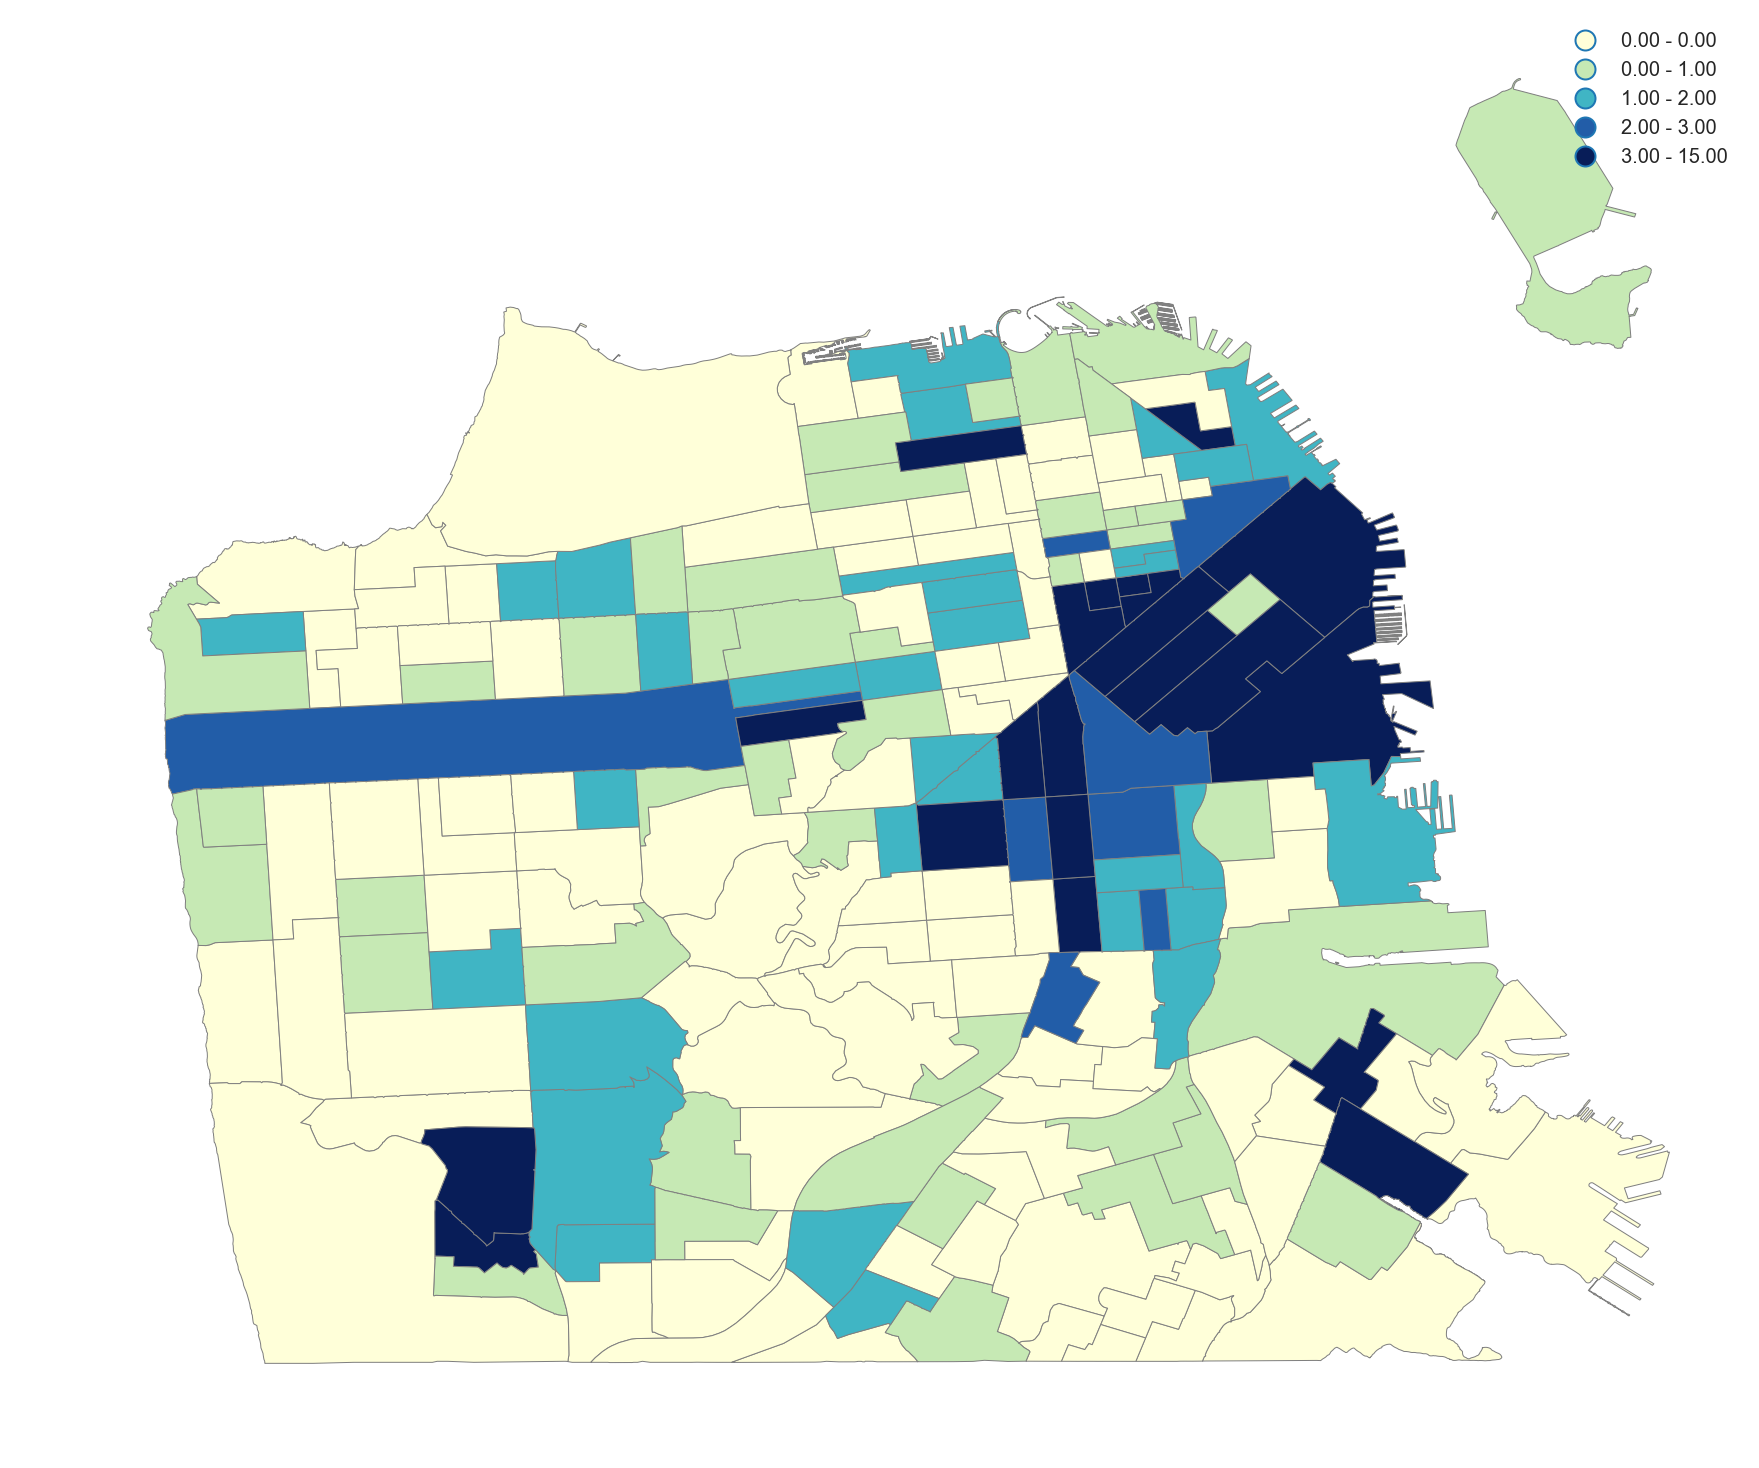

In [36]:
'''COUNT'''
sub_frame_choro(sfcrime, san_fran, col_cat="Category", category='DRUNKENNESS', 
                    col_time='year', num=2017, type_graph=['count'])

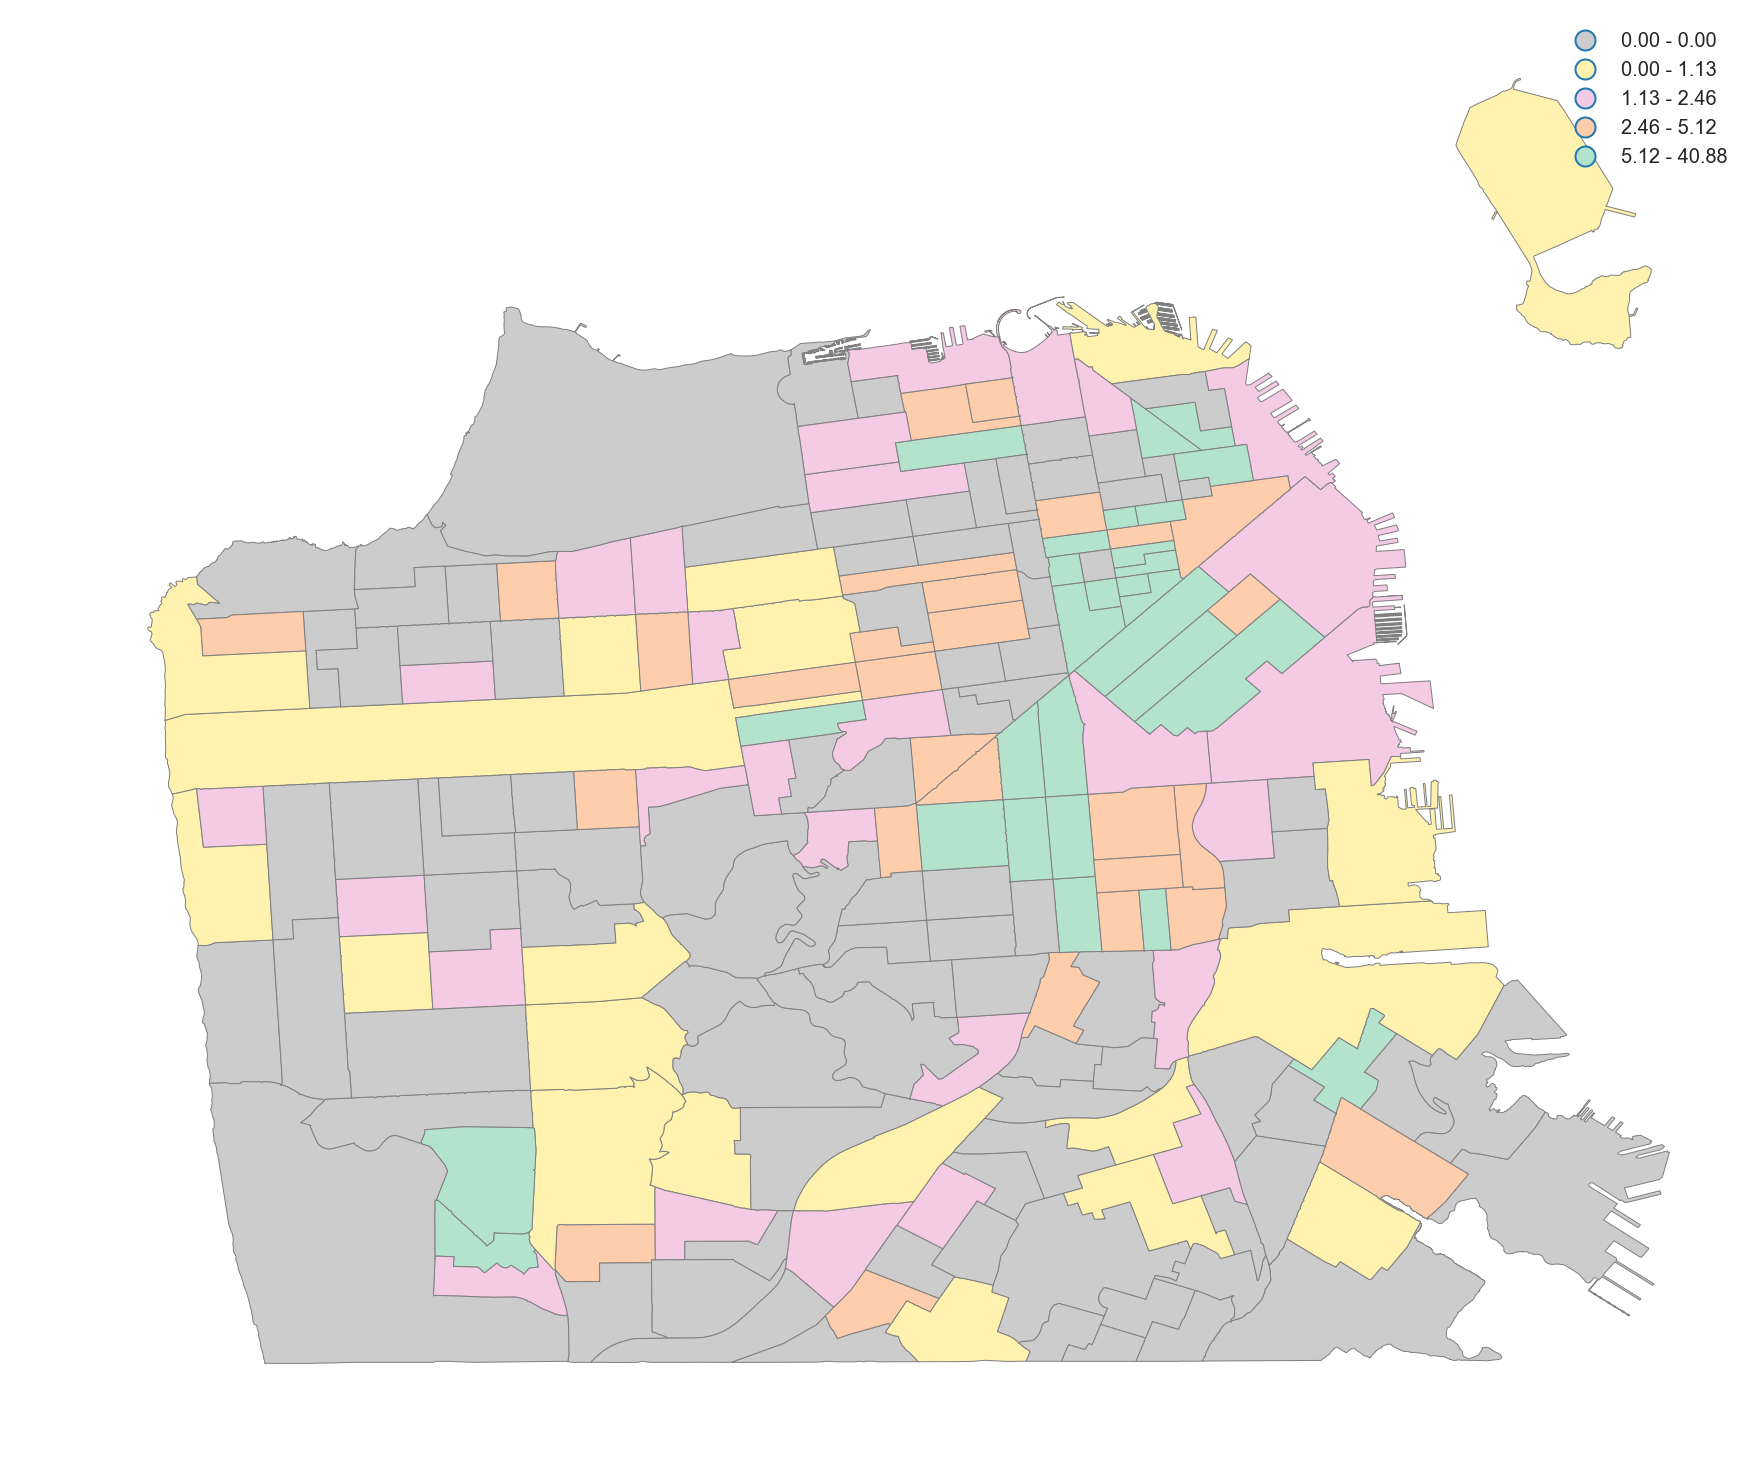

In [37]:
'''DENSITY'''
sub_frame_choro(sfcrime, san_fran, col_cat="Category", category='DRUNKENNESS', 
                    col_time='year', num=2017, type_graph=['density'])

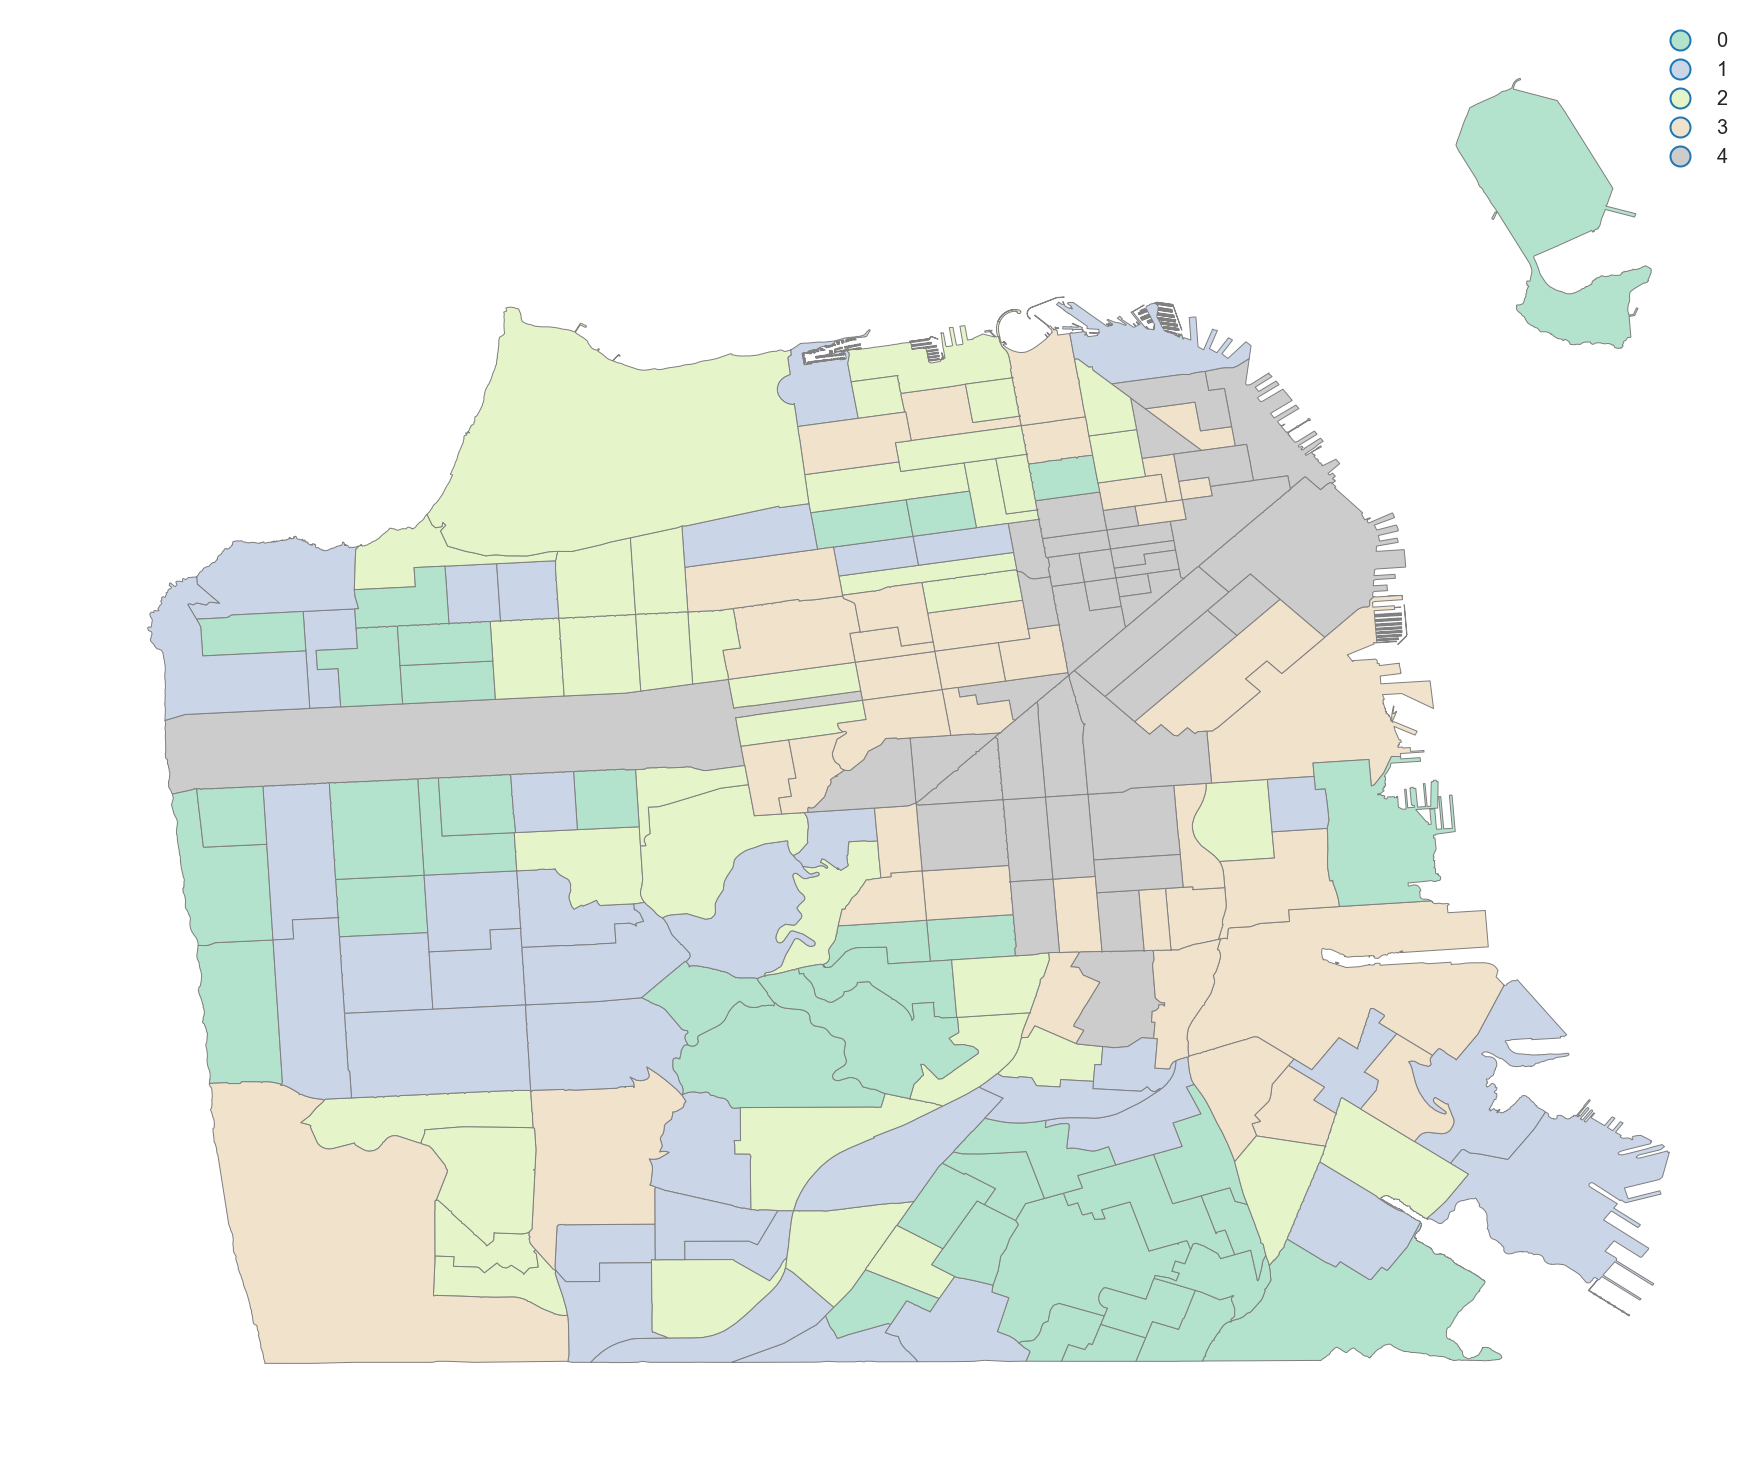

('WARNING: ', 183, ' is an island (no neighbors)')
The Moran's spatial autocorrelation value is: 0.413914370727
It has a p-value of 0.001 which shows that there is a less than 0.1%
probability that the distribution of the data is heavily skewed.


In [38]:
'''SPATIAL LAG'''
sub_frame_choro(sfcrime, san_fran, col_cat="Category", category='DRUNKENNESS', 
                    col_time='year', num=2017, type_graph=['spatial_lag'])